In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
%load_ext zipline

In [3]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output single_factor.pickle --no-benchmark --bundle quandl
##zipline ingest -b quandl提取数据；zipline bundles，查看所有的bundles；

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')

,period_open,period_close,returns,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,...,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,factor_data,prices
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000000,1.000000e+07,0,0,0.000,0.000,0.000,0.000000,...,None,NaN,NaN,0.000000,0.000000,0.0,0.0,1,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,0.000000,1.000000e+07,0,0,0.000,0.000,0.000,0.000000,...,None,NaN,NaN,0.000000,0.000000,0.0,0.0,2,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,-0.000380,9.996201e+06,12,4,4731525.565,-1617262.705,4731525.565,-3799.475085,...,None,-9.165151,-9.165151,-0.000380,0.635120,0.0,0.0,3,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,0.001286,1.000905e+07,12,4,4757100.850,-1629987.410,4757100.850,12850.580000,...,None,4.933673,18.918320,-0.000380,0.638131,0.0,0.0,4,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,0.006366,1.007277e+07,12,4,4835941.280,-1645106.080,4835941.280,63721.760000,...,None,8.194658,135.877107,-0.000380,0.643422,0.0,0.0,5,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,-0.001537,1.102076e+07,12,10,5266915.040,-4598653.320,5266915.040,-16960.030000,...,None,0.406793,0.609931,-0.142578,1.259576,0.0,0.0,751,Equity(0 [A]) 2393.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.66 Equity(1 [AA]) ...
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,-0.003947,1.097727e+07,12,10,5217746.950,-4592983.200,5217746.950,-43497.970000,...,None,0.391704,0.587086,-0.142578,1.259576,0.0,0.0,752,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,0.003758,1.101852e+07,9,13,3966687.510,-5240774.395,3966687.510,41248.841483,...,None,0.405300,0.607626,-0.142578,1.259576,0.0,0.0,753,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,0.002318,1.104406e+07,9,12,3967663.630,-5158764.315,3967663.630,25543.807669,...,None,0.413599,0.620128,-0.142578,1.259576,0.0,0.0,754,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...


In [4]:
result = _

In [5]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   returns                  755 non-null    float64            
 3   portfolio_value          755 non-null    float64            
 4   longs_count              755 non-null    int64              
 5   shorts_count             755 non-null    int64              
 6   long_value               755 non-null    float64            
 7   short_value              755 non-null    float64            
 8   long_exposure            755 non-null    float64            
 9   pnl                      755 non-null    float64            
 10  capital_used             755 non-null    float64 

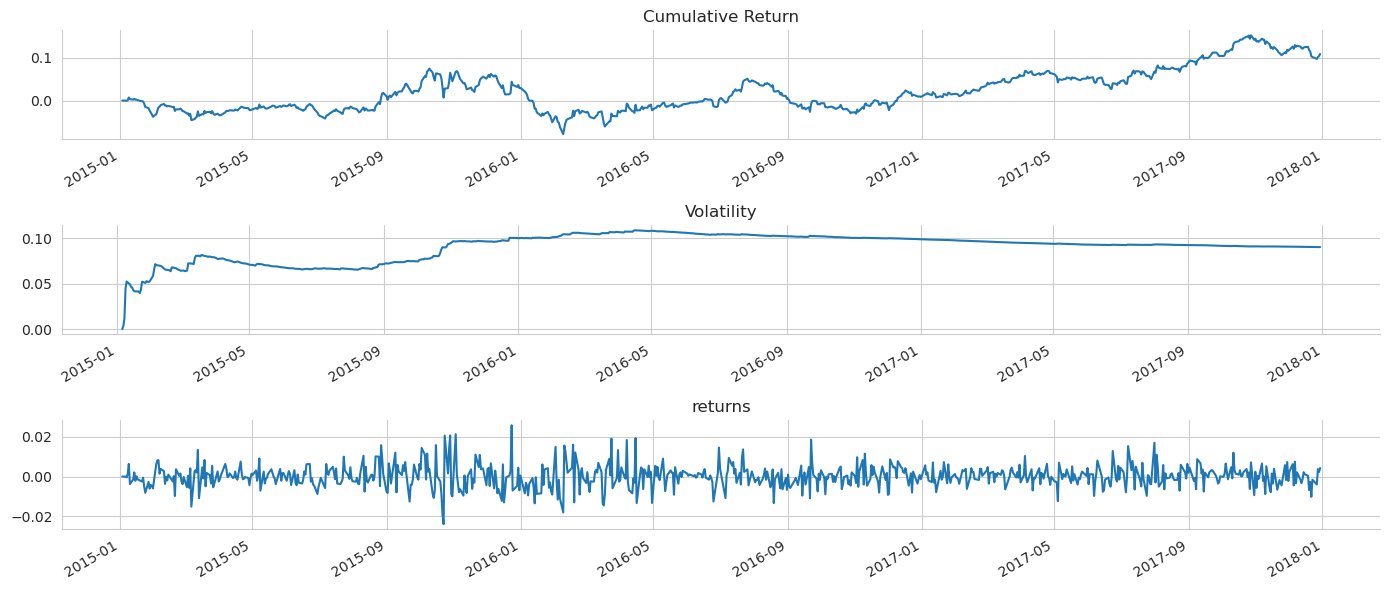

In [7]:
fig, axes = plt.subplots(nrows=3, figsize=(14,6))
result.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
result.algo_volatility.plot(ax=axes[1], title='Volatility')
result.returns.plot(ax=axes[2], title='returns')
sns.despine()
fig.tight_layout();